## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(X_orig, Y_train), (X_test, Y_test) = mnist.load_data()
X_orig = X_orig / 255.0
X_test = X_test / 255.0

## Model

In [3]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(784),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(max_value=1.0),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(max_value=1.0),
    tf.keras.layers.Dense(49),
    tf.keras.layers.ReLU(max_value=1.0) # Keep output from going too high
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(49, 1)),
    tf.keras.layers.Dense(49),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(max_value=1.0),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(max_value=1.0),
    tf.keras.layers.Dense(784),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(max_value=1.0),
    tf.keras.layers.Dense(784),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(max_value=1.0),
    tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(max_value=1.0) # Keep output from going too high
])

contrast = 0.01
rotation = 0.05
height_factor = 0.15
width_factor = 0.15
seed = None

aug = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(contrast),
    tf.keras.layers.RandomRotation(rotation),
    tf.keras.layers.RandomTranslation(height_factor, width_factor),
])
aug.build(input_shape=(28, 28, 1, 1)) # Prevents Ghosting on Batches

layers = [layer for layer in encoder.layers]
layers.extend([layer for layer in decoder.layers])

autoencoder = tf.keras.Sequential(
    layers
)

## Train

In [12]:
optimizer = tf.keras.optimizers.Adam(0.01)
autoencoder.compile(optimizer=optimizer, loss='MSE')
epochs = 25
batch_size = 512
for epoch in range(epochs):
    print('{} of {}'.format(epoch, epochs))
    X_train = aug(X_orig, training=True)
    autoencoder.fit(X_train,
                    X_train,
                    epochs=1,
                    batch_size=batch_size,
                    validation_split=0.1,
                    verbose=2
                   )
print('evaluate')
autoencoder.evaluate(X_test, X_test, verbose=2)
#print(autoencoder.summary())

0 of 25
106/106 - 2s - loss: 0.0130 - val_loss: 0.0223 - 2s/epoch - 22ms/step
1 of 25
106/106 - 1s - loss: 0.0104 - val_loss: 0.0182 - 935ms/epoch - 9ms/step
2 of 25
106/106 - 1s - loss: 0.0094 - val_loss: 0.0181 - 937ms/epoch - 9ms/step
3 of 25
106/106 - 1s - loss: 0.0085 - val_loss: 0.0150 - 948ms/epoch - 9ms/step
4 of 25
106/106 - 1s - loss: 0.0078 - val_loss: 0.0139 - 941ms/epoch - 9ms/step
5 of 25
106/106 - 1s - loss: 0.0075 - val_loss: 0.0126 - 927ms/epoch - 9ms/step
6 of 25
106/106 - 1s - loss: 0.0069 - val_loss: 0.0117 - 925ms/epoch - 9ms/step
7 of 25
106/106 - 1s - loss: 0.0068 - val_loss: 0.0103 - 937ms/epoch - 9ms/step
8 of 25
106/106 - 1s - loss: 0.0064 - val_loss: 0.0091 - 934ms/epoch - 9ms/step
9 of 25
106/106 - 1s - loss: 0.0064 - val_loss: 0.0097 - 909ms/epoch - 9ms/step
10 of 25
106/106 - 1s - loss: 0.0061 - val_loss: 0.0105 - 932ms/epoch - 9ms/step
11 of 25
106/106 - 1s - loss: 0.0059 - val_loss: 0.0090 - 977ms/epoch - 9ms/step
12 of 25
106/106 - 1s - loss: 0.0058 - v

0.01594855636358261

## GRID VID

In [13]:
import cv2

In [14]:
encoder_preds = encoder(np.array(X_test[0:101]))

totalFrames = 100
tiles = 10

# Grid of Latent Spaces and Diffs
latent_grid = []
for i in range(tiles):
    for j in range(tiles):
        predsIdx = i * tiles + j
        this_latent_space = encoder_preds[predsIdx].numpy()
        next_latent_space = encoder_preds[predsIdx + 1].numpy()
        this_diff = (next_latent_space - this_latent_space) / totalFrames
        latent_grid.append([this_latent_space, this_diff])
        

blends = np.zeros(shape=(totalFrames, 28 * tiles, 28 * tiles, 1)).astype(np.uint8)
for frameNum in range(totalFrames):
    for i in range(tiles):
        for j in range(tiles):
            predsIdx = i * tiles + j
            this_latent_space = latent_grid[predsIdx][0] + frameNum * latent_grid[predsIdx][1]
            this_img = decoder(this_latent_space.reshape(1, 49))[0].numpy()
            this_img *= 255
            this_img = this_img.astype(np.uint8)
            blends[frameNum, i*28:(i+1)*28, j*28:(j+1)*28] = this_img
    if frameNum % 10 == 0:
        print('frame {} of {} is done'.format(frameNum, totalFrames))

frame 0 of 100 is done
frame 10 of 100 is done
frame 20 of 100 is done
frame 30 of 100 is done
frame 40 of 100 is done
frame 50 of 100 is done
frame 60 of 100 is done
frame 70 of 100 is done
frame 80 of 100 is done
frame 90 of 100 is done


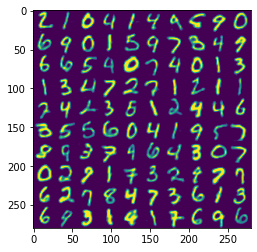

In [15]:
plt.imshow(blends[99])

## MP4

In [16]:
output = 'grid_blend.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, 30, (tiles*28, tiles*28))
            
for i, blend in enumerate(blends):
    if i % 10 == 0:
        print(i)
    out.write(cv2.applyColorMap(cv2.cvtColor(blend, cv2.COLOR_GRAY2RGB), cv2.COLORMAP_JET))
            
out.release()

0
10
20
30
40
50
60
70
80
90


In [17]:
# 0 - 183
# 1 - 37
# 2 - 147
# 3 - 51
# 4 - 48
# 5 - 165
# 6 - 131
# 7 - 64
# 8 - 495
# 9 - 16

## Sorted Grid Vid

In [18]:
encoder_preds = encoder(np.array(X_test[0:500]))

totalFrames = 100
tiles = 10

theIndexes = [183, 37, 147, 51, 48, 165, 131, 64, 495, 16]

the_latent_spaces = []
for idx in theIndexes:
    this_latent_space = encoder_preds[idx].numpy()
    the_latent_spaces.append(this_latent_space)

# Grid of Latent Spaces and Diffs
latent_grid = []
for i in range(tiles):
    for j in range(tiles):
        this_latent_space = the_latent_spaces[i]
        next_latent_space = the_latent_spaces[j]
        this_diff = (next_latent_space - this_latent_space) / totalFrames
        latent_grid.append([this_latent_space, this_diff])

blends = np.zeros(shape=(totalFrames, 28 * tiles, 28 * tiles, 1)).astype(np.uint8)
for frameNum in range(totalFrames):
    for i in range(tiles):
        for j in range(tiles):
            predsIdx = i * tiles + j
            this_latent_space = latent_grid[predsIdx][0] + frameNum * latent_grid[predsIdx][1]
            this_img = decoder(this_latent_space.reshape(1, 49))[0].numpy()
            this_img *= 255
            this_img = this_img.astype(np.uint8)
            blends[frameNum, i*28:(i+1)*28, j*28:(j+1)*28] = this_img
    if frameNum % 10 == 0:
        print('frame {} of {} is done'.format(frameNum, totalFrames))

frame 0 of 100 is done
frame 10 of 100 is done
frame 20 of 100 is done
frame 30 of 100 is done
frame 40 of 100 is done
frame 50 of 100 is done
frame 60 of 100 is done
frame 70 of 100 is done
frame 80 of 100 is done
frame 90 of 100 is done


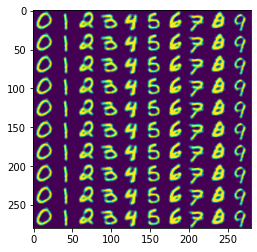

In [19]:
plt.imshow(blends[99])

In [20]:
output = 'sorted_grid_blend.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output, fourcc, 30, (tiles*28, tiles*28))
            
for i, blend in enumerate(blends):
    if i % 10 == 0:
        print(i)
    out.write(cv2.applyColorMap(cv2.cvtColor(blend, cv2.COLOR_GRAY2RGB), cv2.COLORMAP_JET))
            
out.release()

0
10
20
30
40
50
60
70
80
90


### Old Prep Work

This is how I chose which digits looked good so I could blend between "pretty" digits.

In [21]:
allVals = []
for i in range(10):
    found = 0
    theseVals = []
    idx = 0
    while found < 20:
        if i == Y_test[idx]:
            found += 1
            theseVals.append(idx)
        idx += 1
    allVals.append(theseVals)
print(allVals)

[[3, 10, 13, 25, 28, 55, 69, 71, 101, 126, 136, 148, 157, 183, 188, 192, 194, 215, 246, 269], [2, 5, 14, 29, 31, 37, 39, 40, 46, 57, 74, 89, 94, 96, 107, 135, 137, 143, 145, 154], [1, 35, 38, 43, 47, 72, 77, 82, 106, 119, 147, 149, 172, 174, 186, 199, 208, 221, 222, 225], [18, 30, 32, 44, 51, 63, 68, 76, 87, 90, 93, 112, 142, 158, 173, 195, 200, 205, 213, 216], [4, 6, 19, 24, 27, 33, 42, 48, 49, 56, 65, 67, 85, 95, 103, 109, 115, 116, 117, 121], [8, 15, 23, 45, 52, 53, 59, 102, 120, 127, 129, 132, 152, 153, 155, 162, 165, 167, 182, 187], [11, 21, 22, 50, 54, 66, 81, 88, 91, 98, 100, 123, 130, 131, 138, 140, 156, 161, 164, 197], [0, 17, 26, 34, 36, 41, 60, 64, 70, 75, 79, 80, 83, 86, 97, 111, 114, 122, 124, 133], [61, 84, 110, 128, 134, 146, 177, 179, 181, 184, 226, 232, 233, 242, 257, 260, 266, 268, 277, 290], [7, 9, 12, 16, 20, 58, 62, 73, 78, 92, 99, 104, 105, 108, 113, 118, 125, 150, 151, 185]]


290


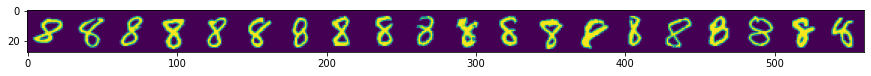

In [22]:
f, axarr = plt.subplots(1, 1, figsize=(15, 15))
blends = np.zeros(shape=(28, 560)).astype(np.float32)
for i, idx in enumerate(allVals[8]):
    blends[:, i*28:(i+1)*28] = X_test[idx]
axarr.imshow(blends)
print(allVals[8][-1])